In [1]:
# Imports for data
import pandas as pd
import numpy as np
import csv
import re

In [2]:
# Read the raw CSV file generated from scraping
df = pd.read_csv('steam_dataframe.csv', index_col = 0)

In [3]:
def cleanPrice(dataframe):
    '''
    Creates a new column of prices titled 'Clean_Price'.
    If '$' is found in 'Price' column, then a cleaning process begins as follows:
    (1) Convert the cell into a string format
    (2) Partition by '\t' (outputs '$X.XX') and collect index [0]
    (3) Split the string by '$' (e.g. '$', 'X.XX') and collect index [1]
    (4) Convert into a float
    (5) The 'except' will remove an improperly formatted row
    Finally, remove games that are more than $80 because these are
    typically bundles and skew the results
    '''
    for row in range(0, len(dataframe)):
        try:
            if '$' in dataframe.loc[row, 'Price']:
                dataframe.loc[row, 'Clean_Price'] = float(str(dataframe.loc[row, 'Price']).partition('\t')[0].split('$')[1])
            else:
                dataframe.loc[row, 'Clean_Price'] = float(0)
        except:
            dataframe.loc[row, 'Clean_Price'] = np.nan
    dataframe.dropna(subset = ['Clean_Price'], inplace = True)
    dataframe = dataframe[dataframe['Clean_Price'] <= 60]
    return dataframe

In [4]:
def makeStorage(dataframe):
    '''
    Creates a new column titled 'Storage_MB'.
    This works by first checking if 'MB' or 'GB' is in the storage column.
    If 'MB' is found, it will take index [1] and convert to integer.
    If 'GB' is found, it will take indx [1], convert to integer, then multiply by 1000.
    '''
    for row in range(0, len(dataframe)):
        try:
            if 'MB' in dataframe.loc[row, 'Storage']:
                dataframe.loc[row, 'Storage_MB'] = float(dataframe.loc[row, 'Storage'].split()[1])
            if 'GB' in dataframe.loc[row, 'Storage']:
                dataframe.loc[row, 'Storage_MB'] = float(dataframe.loc[row, 'Storage'].split()[1]) * 1000
        except:
            dataframe.loc[row, 'Storage_MB'] = np.nan
    dataframe.dropna(subset = ['Storage_MB'], inplace = True)
    return dataframe

In [5]:
def removePreorders(dataframe):
    '''
    Makes the date row into a datetime format.
    If it doesn't work, remove the row.
    '''
    for row in range(0, len(dataframe)):
        try:
            dataframe.loc[row, 'Clean_Release_Date'] = pd.to_datetime(dataframe.loc[row, 'Release_Date'])
        except:
            dataframe.loc[row, 'Clean_Release_Date'] = np.nan
    dataframe.dropna(subset = ['Clean_Release_Date'], inplace = True)
    return dataframe

In [6]:
def makeAllPercentReview(dataframe):
    '''
    Looks through 'All_Perc_Review' column and
    splits the string, returning index [1].
    '''
    for row in range(0, len(dataframe)):
        try:
            dataframe.loc[row,'All_Perc_Review'] = float(dataframe.loc[row,'All_Reviews'].split()[1].strip('%'))
        except:
            dataframe.loc[row, 'All_Perc_Review'] = np.nan
    dataframe.dropna(subset = ['All_Perc_Review'], inplace = True)
    return dataframe

In [7]:
def makeAllNumberReview(dataframe):
    '''
    Looks through 'All_Perc_Review' column and
    splits the string, returning index [4].
    '''
    for row in range(0, len(dataframe)):
        try:
            dataframe.loc[row,'All_Num_Reviews'] = int(dataframe.loc[row,'All_Reviews'].split()[4].replace(',', ''))
        except:
            dataframe.loc[row, 'All_Num_Reviews'] = np.nan
    dataframe.dropna(subset = ['All_Num_Reviews'], inplace = True)
    return dataframe

In [8]:
def makeRecentPercentReview(dataframe):
    '''
    Looks through 'Recent_Perv_review' column and
    splits the string, returning index [1].
    '''
    for row in range(0, len(dataframe)):
        dataframe.loc[row,'Recent_Perc_Review'] = float(dataframe.loc[row,'Recent_Reviews'].split()[1].strip('%'))
    return dataframe

In [9]:
def makeRecentNumberReview(dataframe):
    '''
    Looks through 'Recent_Perv_review' column and
    splits the string, returning index [4].
    '''
    for row in range(0, len(dataframe)):
        dataframe.loc[row,'Recent_Num_Review'] = int(dataframe.loc[row,'Recent_Reviews'].split()[4].replace(',', ''))
    return dataframe

In [10]:
def daysSinceRelease(dataframe):
    '''
    Creates a new column that calculates the amount of days
    it's been since the game's released to July 10, 2020.
    Also, filter out recent games (< 14 days since release)
    because reviews count will be denser near release and
    skew the data
    '''
    for row in range(0, len(dataframe)):
        dataframe.loc[row, 'Days_Since_Release'] = int(str((pd.to_datetime('July 10, 2020') - dataframe.loc[row, 'Clean_Release_Date'])).split()[0])
    dataframe = dataframe[dataframe['Days_Since_Release'] > 14]
    return dataframe

In [11]:
def reviewsPerDay(dataframe):
    '''
    Creates a new column that normalizes the amount
    of reviews by days since release:
    'All_Num_Reviews' / 'Days_Since_Release'
    '''
    for row in range(0, len(dataframe)):
        dataframe.loc[row, 'Reviews_Per_Day'] = float(dataframe.loc[row, 'All_Num_Reviews'] / dataframe.loc[row, 'Days_Since_Release'])
    return dataframe

In [12]:
def isItIndie(dataframe):
    '''
    Initiates a 'Is_It_Indie' column with all rows having value '1'.
    Then searches through 'Genre' column to see if the word 'Indie'
    is contained. If it is, replace '1' with '0'.
    Legend: '1' == yes it is Indie; '0' == no it is NOT Indie.
    '''
    dataframe['Is_It_Indie'] = '1'
    dataframe.loc[~dataframe['Genre'].str.contains('Indie'), 'Is_It_Indie'] = '0'
    return dataframe

In [13]:
def countGenres(dataframe):
    '''
    Splits number of genres by '.' and counts number of genres.
    Axis = 1 will apply to the row (instead of column)
    '''
    dataframe['Num_Genres'] = dataframe.apply(lambda x: int(len(x['Genre'].split(','))), axis = 1)
    return dataframe

In [14]:
df = cleanPrice(df).reset_index(drop = True)
df = makeStorage(df).reset_index(drop = True)
df = removePreorders(df).reset_index(drop = True)
df = makeAllNumberReview(df).reset_index(drop = True)
df = makeAllPercentReview(df).reset_index(drop = True)
df = makeRecentNumberReview(df).reset_index(drop = True)
df = makeRecentPercentReview(df).reset_index(drop = True)
df = isItIndie(df).reset_index(drop = True)
df = countGenres(df).reset_index(drop = True)
df = daysSinceRelease(df).reset_index(drop = True)
df = reviewsPerDay(df).reset_index(drop = True)

In [15]:
df.sample(10)

,All_Reviews,Developer,Genre,Metacritic,Price,Primary_Genre,Publisher,Recent_Reviews,Release_Date,Storage,...,Storage_MB,Clean_Release_Date,All_Num_Reviews,All_Perc_Review,Recent_Num_Review,Recent_Perc_Review,Is_It_Indie,Num_Genres,Days_Since_Release,Reviews_Per_Day
7297,- 78% of the 421 user reviews for this game ar...,"['Shenzhen Huanjing Technology Co.,Ltd']","['Casual', 'Free to Play', 'Indie', 'Strategy']",No Score,Free To Play\t\t\t\t\t\t\n\n\nPlay Game,Casual Games,"['Shenzhen Huanjing Technology Co.,Ltd']",- 46% of the 13 user reviews in the last 30 da...,"Dec 23, 2019",Storage: 256 MB available space,...,256.0,2019-12-23,421.0,78.0,13.0,46.0,1,4,200.0,2.105000
19167,- 10% of the 10 user reviews for this game are...,['EcoGames'],"['Casual', 'Indie', 'Simulation', 'Strategy']",No Score,$5.99\t\t\t\t\t\t\n\n\nAdd to Cart,Simulation Games,['EcoGames'],- 81% of the 11 user reviews in the last 30 da...,"Sep 8, 2017",Storage: 600 MB available space,...,600.0,2017-09-08,10.0,10.0,11.0,81.0,1,4,1036.0,0.009653
16262,- 66% of the 12 user reviews for this game are...,['Mikhail Melnikov'],"['Casual', 'Indie']",No Score,$0.99\t\t\t\t\t\t\n\n\nAdd to Cart,Indie Games,['Mikhail Melnikov'],- 76% of the 13 user reviews in the last 30 da...,"Dec 15, 2017",Storage: 200 MB available space,...,200.0,2017-12-15,12.0,66.0,13.0,76.0,1,2,938.0,0.012793
6155,- 81% of the 61 user reviews for this game are...,['Enlight Software Limited'],"['Casual', 'Simulation', 'Strategy']",No Score,$6.99\t\t\t\t\t\t\n\n\nAdd to Cart,Simulation Games,['Enlight Software Limited'],- 84% of the 13 user reviews in the last 30 da...,"Aug 1, 2004",Storage: 1 GB available space,...,1000.0,2004-08-01,61.0,81.0,13.0,84.0,0,3,5822.0,0.010477
10918,- 100% of the 20 user reviews for this game ar...,['Realore'],"['Adventure', 'Casual', 'Simulation', 'Strategy']",No Score,$2.99\t\t\t\t\t\t\n\n\nAdd to Cart,Adventure Games,['Qumaron'],- 90% of the 11 user reviews in the last 30 da...,"Feb 9, 2016",Storage: 180 MB available space,...,180.0,2016-02-09,20.0,100.0,11.0,90.0,0,4,1613.0,0.012399
10601,- 91% of the 12 user reviews for this game are...,[],[],No Score,$1.99\t\t\t\t\t\t\n\n\nAdd to Cart,Indie Games,[],- 91% of the 34 user reviews in the last 30 da...,"Dec 22, 2016",Storage: 50 MB available space,...,50.0,2016-12-22,12.0,91.0,34.0,91.0,0,1,1296.0,0.009259
17398,- 65% of the 20 user reviews for this game are...,[],[],No Score,$14.99\t\t\t\t\t\t\n\n\nAdd to Cart,Indie Games,[],- 75% of the 12 user reviews in the last 30 da...,"Jun 7, 2018",Storage: 2 GB available space,...,2000.0,2018-06-07,20.0,65.0,12.0,75.0,0,1,764.0,0.026178
7764,- 70% of the 97 user reviews for this game are...,['FX Games'],"['Free to Play', 'Massively Multiplayer', 'Str...",No Score,Free to Play\t\t\t\t\t\t\n\n\nPlay Game,Strategy Games,['FX Games'],- 5% of the 59 user reviews in the last 30 day...,"Jan 1, 2017",Storage: 400 MB available space,...,400.0,2017-01-01,97.0,70.0,59.0,5.0,0,3,1286.0,0.075428
4085,- 97% of the 35 user reviews for this game are...,['Edym Pixels'],['Indie'],No Score,$9.99\t\t\t\t\t\t\n\n\nAdd to Cart,Indie Games,['Edym Pixels'],- 86% of the 15 user reviews in the last 30 da...,"Jan 29, 2020",Storage: 200 MB available space,...,200.0,2020-01-29,35.0,97.0,15.0,86.0,1,1,163.0,0.214724
13600,- 65% of the 842 user reviews for this game ar...,"['Bimboosoft Co.,Ltd.']","['Casual', 'Indie']",No Score,-75%$1.99$0.49 \n\nAdd to Cart,Indie Games,[],- 41% of the 12 user reviews in the last 30 da...,"Jul 7, 2015",Storage: 27 MB available space,...,27.0,2015-07-07,842.0,65.0,12.0,41.0,1,2,1830.0,0.460109


In [16]:
len(df)

19586

In [17]:
# Export dataframe into CSV file (and remove first indexing column)

# df.to_csv('steam_cleaned_dataframe.csv', index = False)

In [18]:
import seaborn as sns

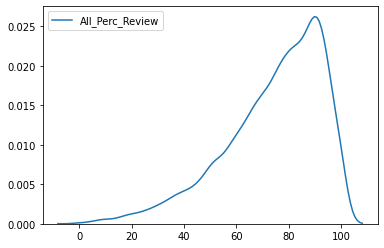

In [20]:
sns.kdeplot(df['All_Perc_Review'])

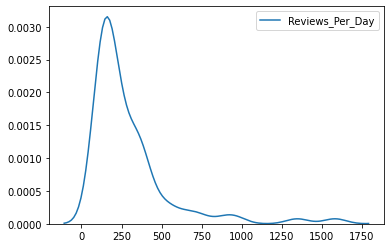

In [22]:
sns.kdeplot(df[df.Reviews_Per_Day > 100]['Reviews_Per_Day'])